# Cross-validation framework

Go into details into the cross-validation framework.

Before we dive in, let's linger on the reasons for always having training and testing sets. Let's first look at the limitation of using a dataset without keeping any samples out.

To illustrate the different concepts, we will use the California housing
dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In this dataset, the aim is to predict the median value of houses in an area
in California. The features collected are based on general real-estate and
geographical information.

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

To simplify future visualization, let's transform the prices from the
100 (k\\$) range to the thousand dollars (k\\$) range.

In [5]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Training error vs testing error

To solve this regression task, we will use a decision tree regressor.

In [6]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

After training the regressor, we would like to know its potential generalization performance once deployed in production. For this purpose, we use the mean absolute error, which gives us an error in the native unit, i.e. k\\$.

In [7]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We get perfect prediction with no error. It is too optimistic and almost
always revealing a methodological problem when doing machine learning.

Indeed, we trained and predicted on the same dataset. Since our decision tree
was fully grown, every sample in the dataset is stored in a leaf node.
Therefore, our decision tree fully memorized the dataset given during `fit`
and therefore made no error when predicting.

This error computed above is called the **empirical error** or **training
error**.

We trained a predictive model to minimize the training error but our aim is
to minimize the error on data that has not been seen during training.

This error is also called the **generalization error** or the "true"
**testing error**.

Thus, the most basic evaluation involves:

* splitting our dataset into two subsets: a training set and a testing set;
* fitting the model on the training set;
* estimating the training error on the training set;
* estimating the testing error on the testing set.

So let's split our dataset.

In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

Then, let's train our model.

In [9]:
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

Finally, we estimate the different types of errors. Let's start by computing the training error.

In [10]:
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


We observe the same phenomena as in the previous experiment: our model memorized the training set. However, we now compute the testing error.

In [11]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


This testing error is actually about what we would expect from our model if it was used in a production environment.

## Stability of the cross-validation estimates

When doing a single train-test split we don't give any indication regarding
the robustness of the evaluation of our predictive model: in particular, if
the test set is small, this estimate of the testing error will be unstable and
wouldn't reflect the "true error rate" we would have observed with the same
model on an unlimited amount of test data.

For instance, we could have been lucky when we did our random split of our
limited dataset and isolated some of the easiest cases to predict in the
testing set just by chance: the estimation of the testing error would be
overly optimistic, in this case.

**Cross-validation** allows estimating the robustness of a predictive model by
repeating the splitting procedure. It will give several training and testing
errors and thus some **estimate of the variability of the model generalization
performance**.

There are [different cross-validation
strategies](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators),
for now we are going to focus on one called "shuffle-split". At each iteration
of this strategy we:

- randomly shuffle the order of the samples of a copy of the full dataset;
- split the shuffled dataset into a train and a test set;
- train a new model on the train set;
- evaluate the testing error on the test set.

We repeat this procedure `n_splits` times. Keep in mind that the computational
cost increases with `n_splits`.

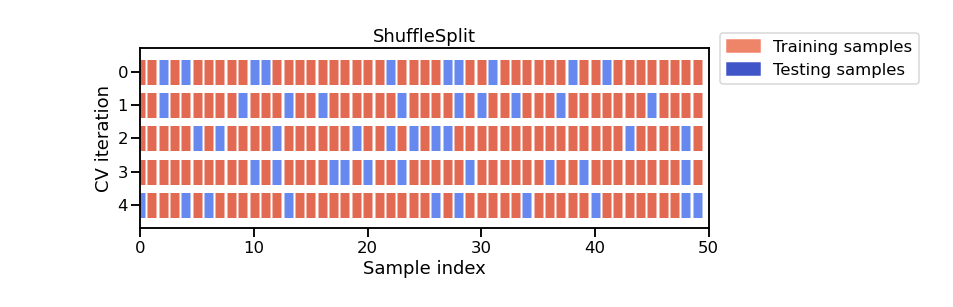

In this case we will set `n_splits=40`, meaning that we will train 40 models
in total and all of them will be discarded: we just record their
generalization performance on each variant of the test set.

In [12]:
from sklearn.model_selection import (
    cross_validate,
    ShuffleSplit
)

cv = ShuffleSplit(n_splits=40, test_size=.3, random_state=0)
cv_results = cross_validate(
    regressor, 
    data, 
    target, 
    cv=cv, 
    scoring='neg_mean_absolute_error'
)

In [13]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.244349,0.006374,-46.909797
1,0.207983,0.004382,-46.421170
2,0.162671,0.005467,-47.411089
3,0.175248,0.004385,-44.319824
4,0.172271,0.005316,-47.607875


A score is a metric for which higher values mean better results. On the contrary, an error is a metric for which lower values mean better results. The parameter scoring in cross_validate always expect a function that is a score.

To make it easy, all error metrics in scikit-learn, like mean_absolute_error, can be transformed into a score to be used in cross_validate. To do so, you need to pass a string of the error metric with an additional neg_ string at the front to the parameter scoring; for instance scoring="neg_mean_absolute_error". In this case, the negative of the mean absolute error will be computed which would be equivalent to a score.

Let us revert the negation to get the actual error:

In [14]:
cv_results['test_error'] = -cv_results['test_score']

Let's check the results reported by the cross-validation.

In [16]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.244349,0.006374,-46.909797,46.909797
1,0.207983,0.004382,-46.421170,46.421170
2,0.162671,0.005467,-47.411089,47.411089
3,0.175248,0.004385,-44.319824,44.319824
4,0.172271,0.005316,-47.607875,47.607875
5,0.166171,0.004449,-45.901300,45.901300
6,0.166897,0.004436,-46.572767,46.572767
7,0.179103,0.004579,-46.194585,46.194585
8,0.167248,0.004305,-45.590236,45.590236
9,0.165279,0.004693,-45.727998,45.727998


We get 40 entries in our resulting dataframe because we performed 40 splits.
Therefore, we can show the testing error distribution and thus, have an
estimate of its variability.

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

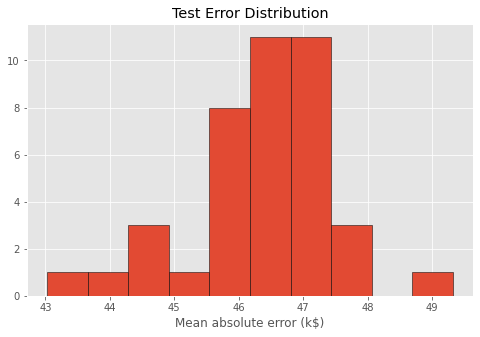

In [20]:
plt.figure(figsize=(8,5))
plt.hist(cv_results['test_error'],bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
plt.title('Test Error Distribution')
plt.show();